# Topic modelling

## Overview of the topics on the forum : http://forums.thefashionspot.com



In [1]:
import csv
import os # added this import to process files/dirs
import re
import numpy as np
import pandas as pd
from __future__ import print_function
from time import time

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline 

import nltk
#nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag

from sklearn.feature_extraction import text
from sklearn.decomposition import LatentDirichletAllocation as lda
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

Import the dataset, here it is the posts scrapped from the folder 'Designers and Collections' (i.e folder 0).
I kept only the text of the posts to apply the LDA algorithm.
Since all posts

In [2]:
print("Loading dataset...")
all_posts= pd.read_csv('posts_folder0.csv',parse_dates=['time'])
print('Dataset size: {}'.format(all_posts.shape))
all_posts.head()

Loading dataset...
Dataset size: (3275, 8)


,ID,Thread ID,author,number,post,quote,tag,time
0,NaN,162311,Chanelcouture09,1,Moderator's Note: Falsely or non credited pi...,[],[],04-01-2012
1,NaN,162311,PonyShow,2,Credit: suninscorpio.tumblr.com,[],[],04-01-2012
2,NaN,162311,Chanelcouture09,3,^John Galliano Fall Winter 2009.,[],[],04-01-2012
3,NaN,162311,Menace,4,If the insect blouse and rainbow dress are ...,[],[],06-01-2012
4,NaN,162311,get fashion,5,The dress it's Christopher Kane Reso...,[],[],06-01-2012


In [3]:
dataset=all_posts['post']
print('Dataset size: {}'.format(dataset.size))
dataset.head()

Dataset size: 3275


0     Moderator's Note:  Falsely or non credited pi...
1                  Credit: suninscorpio.tumblr.com    
2                 ^John Galliano Fall Winter 2009.    
3       If the insect blouse and rainbow dress are ...
4              The dress it's Christopher Kane Reso...
Name: post, dtype: object

### Use LDA to find topics in the entire dataset (later it will correspond to the overview of the forum)

The proper nouns are stripped from the posts text. As we expect them to correspond to brands or designers in most part, I will used them later to try to detect trends. Numbers and months which are added to stop-words are also stripped from the text. I'm still not sure how to incomporate the months, as they could represent seasons which regulate the collections (i.e F/W collection of Zara), hence they will maybe used later.


Paramters to change:
* **n_features**: number of words in the dictionnary
* **n_components**: number of topics to detect
* **n_top_words**: the n most important words in each topics (to share to have insight about the topic)

In [4]:
n_features = 3000
n_components =  10  
n_top_words = 5

In [5]:
#print top words in each detected topics
def print_top_words(model, feature_names, n_top_words):
    topics_dataset=pd.DataFrame(columns=['Topic ID', 'Words'])
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        topic_id= topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        words=[feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(message)
        topics_dataset= topics_dataset.append(pd.DataFrame([[topic_id, words ]],columns=['Topic ID', 'Words']))
    return  topics_dataset
    print()

#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
def strip_proppers(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return ' '.join(non_propernouns)

# compute lda model, tf, topics-words dataset, words-indices map
def LDA(n_samples,n_features,n_components,n_top_words,data_samples):
    # Use tf (raw term count) features for LDA.
    print("Extracting tf features for LDA...")
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                    max_features=n_features,stop_words=set(my_stop_words)
                                    ,token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', ngram_range=(1,3))
    tf = tf_vectorizer.fit_transform(data_samples)

    print("Fitting LDA models with tf features, " "n_samples=%d and n_features=%d..." % (n_samples, n_features))
    lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,learning_method='online',learning_offset=50.,random_state=0)

    lda.fit(tf)

    print("\nTopics in LDA model:")
    tf_feature_names = tf_vectorizer.get_feature_names()
    topics_dataset=print_top_words(lda, tf_feature_names, n_top_words)
    
    return lda,tf, topics_dataset, tf_feature_names


#adding months as stop words
months=['january', 'february', 'march','april', 'may','june', 'july','august', 'september','october','november','december']
my_stop_words = text.ENGLISH_STOP_WORDS.union(months)

#remove proper names
dataset = [strip_proppers(thread) for thread in dataset]

#take the entire dataset
n_samples = len(dataset) 
data_samples = dataset

lda, tf, topics_words, tf_feature_names=LDA(n_samples,n_features,n_components,n_top_words,data_samples)

Extracting tf features for LDA...
Fitting LDA models with tf features, n_samples=3275 and n_features=3000...

Topics in LDA model:
Topic #0: gowns tacky oh wow source
Topic #1: runner ccp fenrost carol yes
Topic #2: couture collection dior film news
Topic #3: t s like think just
Topic #4: thank funny pics belongs omg
Topic #5: com posted dress s collection
Topic #6: s fashion designer house director
Topic #7: vs livingly thanks id spring
Topic #8: balenciaga blue night cat quite frankly
Topic #9: credit photo img credit vogue copy


### Distribution of topics in each post

Add the distributions of topics for each posts in the dataset.

In [6]:
#add doc-topic distribution to the dataset
def add_doc_topic_distrib(lda, tf, dataset, new_col_name):
    res=lda.transform(tf)
    dataset[new_col_name]=res.tolist()
    return dataset

all_posts = add_doc_topic_distrib(lda,tf,all_posts, 'topic distribution')
all_posts.head()


,ID,Thread ID,author,number,post,quote,tag,time,topic distribution
0,NaN,162311,Chanelcouture09,1,Moderator's Note: Falsely or non credited pi...,[],[],04-01-2012,"[0.004347826455096753, 0.004348501629177576, 0..."
1,NaN,162311,PonyShow,2,Credit: suninscorpio.tumblr.com,[],[],04-01-2012,"[0.025000143072399974, 0.025000004488232034, 0..."
2,NaN,162311,Chanelcouture09,3,^John Galliano Fall Winter 2009.,[],[],04-01-2012,"[0.05000000033693303, 0.05000908980709743, 0.0..."
3,NaN,162311,Menace,4,If the insect blouse and rainbow dress are ...,[],[],06-01-2012,"[0.29256830348508417, 0.007693787778027817, 0...."
4,NaN,162311,get fashion,5,The dress it's Christopher Kane Reso...,[],[],06-01-2012,"[0.014285988969944447, 0.01428575198031794, 0...."


### Distribution of the topics over the posts for each month

Compute the mean of the topics' distribution over all the posts of a month. Enable us to see prominent topics over time.

  Topic ID                                          Words
0        0                [gowns, tacky, oh, wow, source]
0        1             [runner, ccp, fenrost, carol, yes]
0        2        [couture, collection, dior, film, news]
0        3                      [t, s, like, think, just]
0        4             [thank, funny, pics, belongs, omg]
0        5            [com, posted, dress, s, collection]
0        6        [s, fashion, designer, house, director]
0        7             [vs, livingly, thanks, id, spring]
0        8  [balenciaga, blue, night, cat, quite frankly]
0        9       [credit, photo, img, credit vogue, copy]


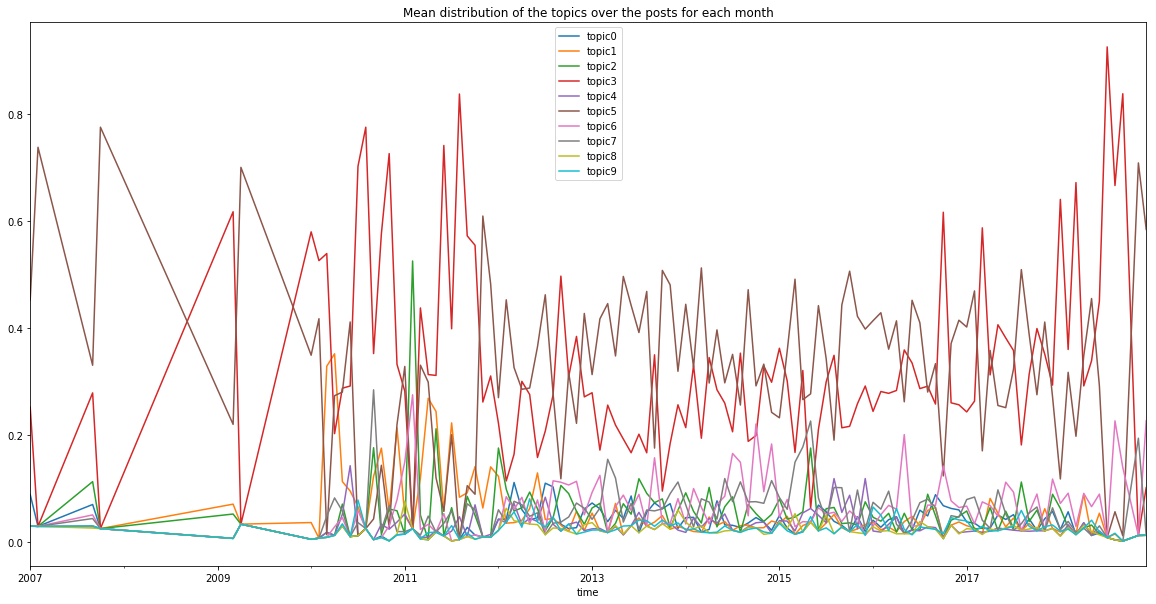

In [7]:
def topics_time_distrib(dataset, distrib_col, topic_dataset):
    # distrubtion of topics over the docs
    topics_time=pd.DataFrame(columns=['time'] +  ['topic%d'%i for i in range(topic_dataset.shape[0])])
    dataset['year_months']=pd.to_datetime(dataset['time'], errors='coerce').dt.to_period('M')

    #for each months compute the mean distribution of topics over the docs (here posts)
    for name, group in dataset.groupby('year_months'):
        distrib = np.asarray(list(group[distrib_col])).mean(axis=0)
        df= pd.DataFrame([[name] + list(distrib)], columns=['time'] + ['topic%d'%i for i in range(topic_dataset.shape[0])] )
        topics_time=topics_time.append(df, ignore_index=True)
    
    topics_time=topics_time.sort_values(by='time')
    time=topics_time['time']
    topics_time=topics_time.set_index('time')
    topics_time=topics_time.reset_index()
    return topics_time

topics_time =topics_time_distrib(all_posts,'topic distribution', topics_words)
print(topics_words)
topics_time.plot(x='time', figsize=(20,10)) 
plt.title('Mean distribution of the topics over the posts for each month')

### Distribution of topics over all the posts of the datatset 
Compute the mean of the topics distribution over all the posts. Enables us to see prominent topics in the dataset.

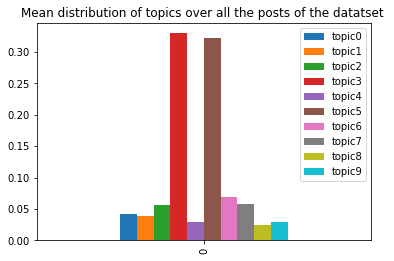

In [8]:
def topics_forum_distrib(dataset, distrib_col, topic_dataset):
    # distrubtion of topics over the docs
    topics_forum=pd.DataFrame(columns= ['topic%d'%i for i in range(topic_dataset.shape[0])])
    
    distrib = np.asarray(list(dataset[distrib_col])).mean(axis=0)
    df= pd.DataFrame([list(distrib)], columns= ['topic%d'%i for i in range(topic_dataset.shape[0])])
    topics_forum=topics_forum.append(df, ignore_index=True)
    
    topics_forum.plot(kind='bar')
    return topics_forum
topics_forum= topics_forum_distrib(all_posts, 'topic distribution', topics_words)
plt.title('Mean distribution of topics over all the posts of the datatset ')


### Words count in the dataset 
For each n_top word in each topic, compute its count over all the dataset.

In [9]:

#for each topic print the number of times the word appears in all posts
def topics_words_distrib(topics_dataset, tf_feature_names, tf):
    #for each topic
    topics_words_count=pd.Series()
    for name, group in topics_dataset.groupby('Topic ID'):
        #for each word
        counts=[]
        for word in group['Words'][0]:
            #find the number of time it appears in the all forum
            #find ind of word in features name
            ind = tf_feature_names.index(word)
            #compute sum of tf column to have #times the word appear in the hole dataset
            counts.append(tf[:,ind].sum())
        topics_words_count= topics_words_count.append(pd.Series([counts]))
    topics_dataset['Words count in dataset']=topics_words_count
    return topics_dataset

topics_words= topics_words_distrib(topics_words, tf_feature_names, tf)
topics_words.head()
    
            

    

,Topic ID,Words,Words count in dataset
0,0,"[gowns, tacky, oh, wow, source]","[46, 46, 40, 25, 91]"
0,1,"[runner, ccp, fenrost, carol, yes]","[44, 38, 33, 27, 60]"
0,2,"[couture, collection, dior, film, news]","[271, 637, 46, 34, 91]"
0,3,"[t, s, like, think, just]","[1015, 1483, 846, 485, 516]"
0,4,"[thank, funny, pics, belongs, omg]","[55, 21, 32, 12, 12]"


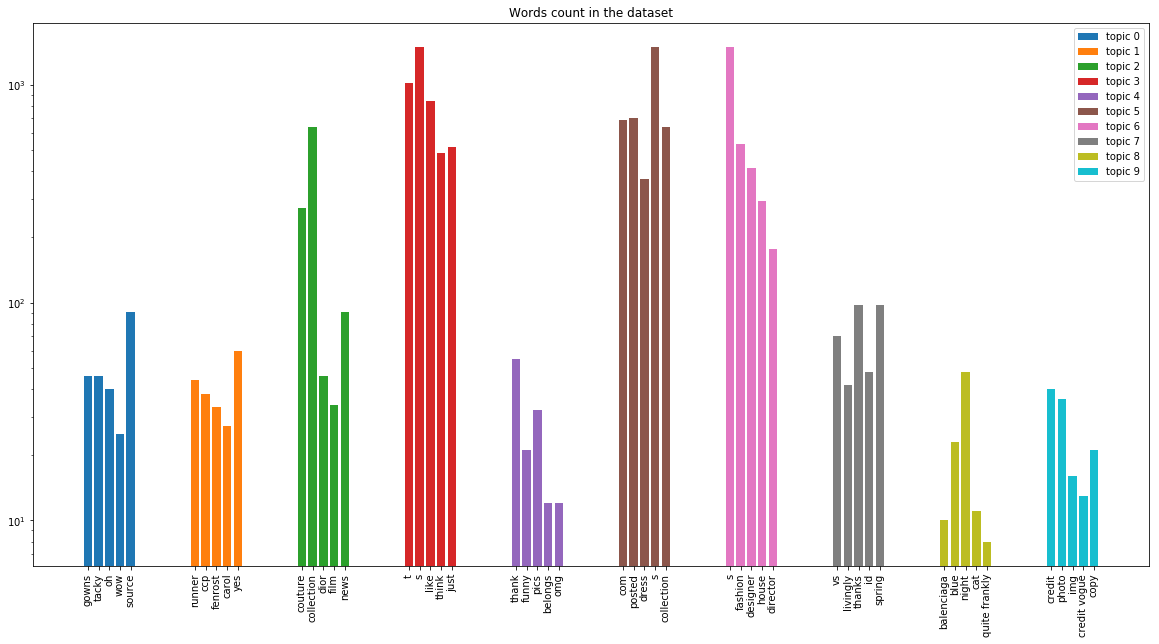

In [10]:
fig, ax= plt.subplots(figsize=(20,10))
tick_label=[]
tick_loc=[]
for i in range(topics_words.shape[0]):
    topic = topics_words.iloc[i]
    x= [0,1,2,3,4]
    x= [y+i*10 for y in x]
    tick_label=tick_label + topic['Words']
    tick_loc=tick_loc + x
    ax.bar(left=x, height=topic['Words count in dataset'], align='center', label='topic %d'%i)

plt.legend(loc='best')
ax.set_xticks(tick_loc)    
ax.set_xticklabels(tick_label,rotation='vertical')
ax.set_yscale('log')
plt.title('Words count in the dataset')
plt.show()


In [11]:
#words count per month per topic 
def words_count_time(topics_dataset, tf, tf_feature_names,dataset):
    #for each topic 
    dataset['year_months']=pd.to_datetime(dataset['time'], errors='coerce').dt.to_period('M')
    words_count_time=pd.DataFrame()
    time=dataset['year_months'].unique()
    print(time)
    for name, group in topics_dataset.groupby('Topic ID'):
        # for each word
        for word in group['Words'][0]:
            #find ind of word 
            ind_word = tf_feature_names.index(word)
            word_counts=[]
            for name , group in dataset.groupby('year_months'):
                print(name)
                #get ind of docs in that period
                ind_doc = list(group.index)
                #get counts of this word in that period
                word_counts= word_counts  + list(np.ndarray.flatten(np.asarray(tf[ind_doc,ind_word].sum(axis=0))));
                
            words_count_time[word]= pd.Series(word_counts)
    print('time size {}'.format(time.shape))
    print(time.sort())
    print('words count size {}'.format(words_count_time.shape))
    return words_count_time

words_count =words_count_time(topics_words, tf, tf_feature_names,all_posts)
print(words_count.head())
for name, topic in topics_words.groupby('Topic ID') :
    plt.figure(figsize=(20,5))
    for word in topic['Words'][0]:
        plt.plot( words_count[word], label=word)
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.title('Word count for words in topic %d'%name)
    plt.show()


[Period('2012-04', 'M') Period('2012-06', 'M') Period('2012-02', 'M')
 Period('2012-05', 'M') Period('2012-07', 'M') Period('2012-12', 'M')
 Period('2012-03', 'M') Period('2012-01', 'M') Period('2012-08', 'M')
 Period('2012-10', 'M') Period('2012-11', 'M') Period('2012-09', 'M')
 Period('2013-09', 'M') Period('2013-01', 'M') Period('2013-02', 'M')
 Period('2013-03', 'M') Period('2013-11', 'M') Period('2013-06', 'M')
 Period('2013-07', 'M') Period('2013-08', 'M') Period('2013-05', 'M')
 Period('2013-04', 'M') Period('2013-10', 'M') Period('2013-12', 'M')
 Period('2014-01', 'M') Period('2014-04', 'M') Period('2014-03', 'M')
 Period('2014-06', 'M') Period('2014-07', 'M') Period('2014-05', 'M')
 Period('2014-10', 'M') Period('2014-11', 'M') Period('2014-08', 'M')
 Period('2014-09', 'M') Period('2014-12', 'M') Period('2015-06', 'M')
 Period('2015-02', 'M') Period('2015-05', 'M') Period('2015-09', 'M')
 Period('2015-11', 'M') Period('2015-03', 'M') Period('2015-04', 'M')
 Period('2015-01', '

2007-01
2007-02
2007-09
2007-10
2009-03
2009-04
2010-01
2010-02
2010-03
2010-04
2010-05
2010-06
2010-07
2010-08
2010-09
2010-10
2010-11
2010-12
2011-01
2011-02
2011-03
2011-04
2011-05
2011-06
2011-07
2011-08
2011-09
2011-10
2011-11
2011-12
2012-01
2012-02
2012-03
2012-04
2012-05
2012-06
2012-07
2012-08
2012-09
2012-10
2012-11
2012-12
2013-01
2013-02
2013-03
2013-04
2013-05
2013-06
2013-07
2013-08
2013-09
2013-10
2013-11
2013-12
2014-01
2014-02
2014-03
2014-04
2014-05
2014-06
2014-07
2014-08
2014-09
2014-10
2014-11
2014-12
2015-01
2015-02
2015-03
2015-04
2015-05
2015-06
2015-07
2015-08
2015-09
2015-10
2015-11
2015-12
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
2018-11
2018-12
2007-01
2007-02
2007-09
2007-10
2009-03
2009-04
2010-01
2010-02
2010-03
2010-04
2010-05
2010-06


2007-01
2007-02
2007-09
2007-10
2009-03
2009-04
2010-01
2010-02
2010-03
2010-04
2010-05
2010-06
2010-07
2010-08
2010-09
2010-10
2010-11
2010-12
2011-01
2011-02
2011-03
2011-04
2011-05
2011-06
2011-07
2011-08
2011-09
2011-10
2011-11
2011-12
2012-01
2012-02
2012-03
2012-04
2012-05
2012-06
2012-07
2012-08
2012-09
2012-10
2012-11
2012-12
2013-01
2013-02
2013-03
2013-04
2013-05
2013-06
2013-07
2013-08
2013-09
2013-10
2013-11
2013-12
2014-01
2014-02
2014-03
2014-04
2014-05
2014-06
2014-07
2014-08
2014-09
2014-10
2014-11
2014-12
2015-01
2015-02
2015-03
2015-04
2015-05
2015-06
2015-07
2015-08
2015-09
2015-10
2015-11
2015-12
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
2018-11
2018-12
2007-01
2007-02
2007-09
2007-10
2009-03
2009-04
2010-01
2010-02
2010-03
2010-04
2010-05
2010-06


2007-01
2007-02
2007-09
2007-10
2009-03
2009-04
2010-01
2010-02
2010-03
2010-04
2010-05
2010-06
2010-07
2010-08
2010-09
2010-10
2010-11
2010-12
2011-01
2011-02
2011-03
2011-04
2011-05
2011-06
2011-07
2011-08
2011-09
2011-10
2011-11
2011-12
2012-01
2012-02
2012-03
2012-04
2012-05
2012-06
2012-07
2012-08
2012-09
2012-10
2012-11
2012-12
2013-01
2013-02
2013-03
2013-04
2013-05
2013-06
2013-07
2013-08
2013-09
2013-10
2013-11
2013-12
2014-01
2014-02
2014-03
2014-04
2014-05
2014-06
2014-07
2014-08
2014-09
2014-10
2014-11
2014-12
2015-01
2015-02
2015-03
2015-04
2015-05
2015-06
2015-07
2015-08
2015-09
2015-10
2015-11
2015-12
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
2018-11
2018-12
2007-01
2007-02
2007-09
2007-10
2009-03
2009-04
2010-01
2010-02
2010-03
2010-04
2010-05
2010-06


2007-01
2007-02
2007-09
2007-10
2009-03
2009-04
2010-01
2010-02
2010-03
2010-04
2010-05
2010-06
2010-07
2010-08
2010-09
2010-10
2010-11
2010-12
2011-01
2011-02
2011-03
2011-04
2011-05
2011-06
2011-07
2011-08
2011-09
2011-10
2011-11
2011-12
2012-01
2012-02
2012-03
2012-04
2012-05
2012-06
2012-07
2012-08
2012-09
2012-10
2012-11
2012-12
2013-01
2013-02
2013-03
2013-04
2013-05
2013-06
2013-07
2013-08
2013-09
2013-10
2013-11
2013-12
2014-01
2014-02
2014-03
2014-04
2014-05
2014-06
2014-07
2014-08
2014-09
2014-10
2014-11
2014-12
2015-01
2015-02
2015-03
2015-04
2015-05
2015-06
2015-07
2015-08
2015-09
2015-10
2015-11
2015-12
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
2018-11
2018-12
2007-01
2007-02
2007-09
2007-10
2009-03
2009-04
2010-01
2010-02
2010-03
2010-04
2010-05
2010-06


2007-01
2007-02
2007-09
2007-10
2009-03
2009-04
2010-01
2010-02
2010-03
2010-04
2010-05
2010-06
2010-07
2010-08
2010-09
2010-10
2010-11
2010-12
2011-01
2011-02
2011-03
2011-04
2011-05
2011-06
2011-07
2011-08
2011-09
2011-10
2011-11
2011-12
2012-01
2012-02
2012-03
2012-04
2012-05
2012-06
2012-07
2012-08
2012-09
2012-10
2012-11
2012-12
2013-01
2013-02
2013-03
2013-04
2013-05
2013-06
2013-07
2013-08
2013-09
2013-10
2013-11
2013-12
2014-01
2014-02
2014-03
2014-04
2014-05
2014-06
2014-07
2014-08
2014-09
2014-10
2014-11
2014-12
2015-01
2015-02
2015-03
2015-04
2015-05
2015-06
2015-07
2015-08
2015-09
2015-10
2015-11
2015-12
2016-01
2016-02
2016-03
2016-04
2016-05
2016-06
2016-07
2016-08
2016-09
2016-10
2016-11
2016-12
2017-01
2017-02
2017-03
2017-04
2017-05
2017-06
2017-07
2017-08
2017-09
2017-10
2017-11
2017-12
2018-01
2018-02
2018-03
2018-04
2018-05
2018-06
2018-07
2018-08
2018-09
2018-11
2018-12
2007-01
2007-02
2007-09
2007-10
2009-03
2009-04
2010-01
2010-02
2010-03
2010-04
2010-05
2010-06


TypeError: Cannot compare type 'Period' with type 'float'

## Proper Nouns

In [12]:
 # Try on proper Nouns

#keep propers nouns
def keep_propers(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    propernouns = [word for word,pos in tagged if pos == 'NNP' or pos == 'NNPS']
    return ' '.join(propernouns)

#keep proper names
print("Keeping only the text")
dataset=all_posts['post']
data_samples = [keep_propers(thread) for thread in dataset]

print("Extracting tf features for proper nouns..")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,stop_words=set(my_stop_words)
                                ,token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*\\b', ngram_range=(1, 3))
tf = tf_vectorizer.fit_transform(data_samples)

tf_feature_names = tf_vectorizer.get_feature_names()
tf_overall= tf.sum(axis=0)

proper_nouns_count=pd.DataFrame()
proper_nouns_count['proper nouns']=pd.Series(tf_feature_names)
proper_nouns_count['count']=pd.Series(np.squeeze(np.asarray(tf_overall)))
proper_nouns_count =proper_nouns_count.sort_values(by='count', ascending=False)
proper_nouns_count=proper_nouns_count.set_index('proper nouns')
proper_nouns_count.head()


Keeping only the text
Extracting tf features for proper nouns..


,count
proper nouns,
s,1469
quote,757
originally,633
quote originally,631
dior,625


In [13]:
proper_nouns_count.head(100)

,count
proper nouns,
s,1469
quote,757
originally,633
quote originally,631
dior,625
simons,377
m,321
raf,265
s s,218


In [14]:
proper_nouns_count_100 =proper_nouns_count.drop(['s', 'quote','originally','quote originally', 'fall','m','w','f','ve', 'd'], axis=0)

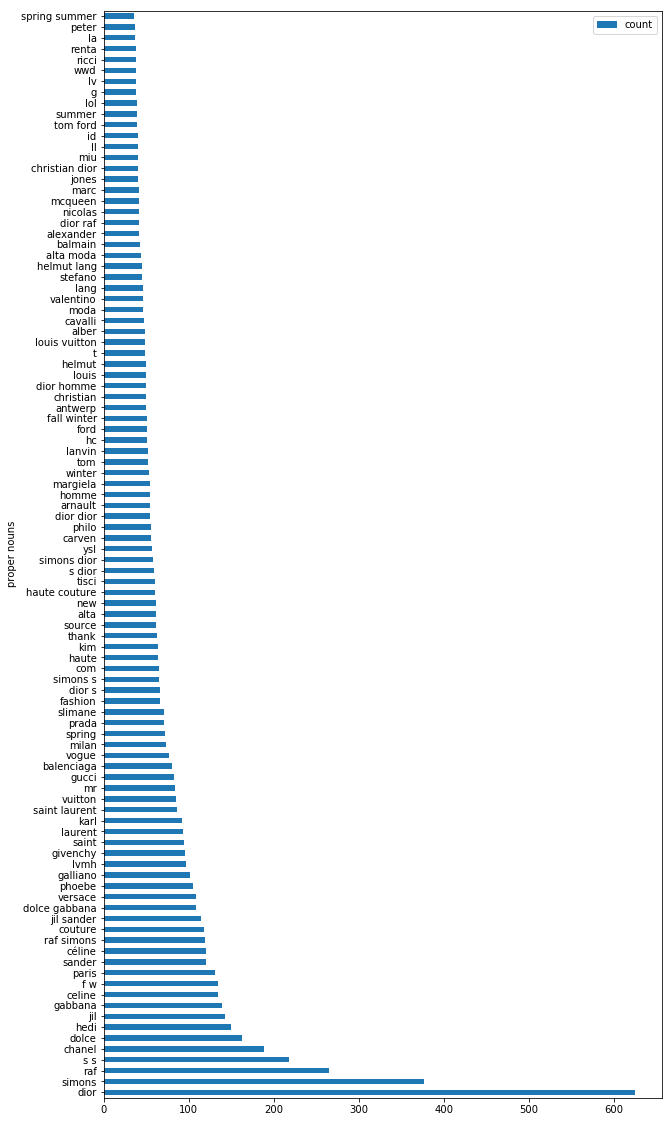

In [15]:

proper_nouns_count_100.head(100).plot(kind='barh', figsize=(10,20))

In [16]:
#words count per month per topic 
def proper_nouns_count_time(proper_nouns_count, tf, tf_feature_names,dataset):
    #for each topic 
    dataset['year_months']=pd.to_datetime(dataset['time'], errors='coerce').dt.to_period('M')
    words_count_time=pd.DataFrame()
    time=dataset['year_months'].unique()
    print(time)
    
    # for each word
    for word in proper_nouns_count['proper nouns']:
        #find ind of word 
        ind_word = tf_feature_names.index(word)
        word_counts=[]
        for name , group in dataset.groupby('year_months'):
            print(name)
            #get ind of docs in that period
            ind_doc = list(group.index)
            #get counts of this word in that period
            word_counts= word_counts  + list(np.ndarray.flatten(np.asarray(tf[ind_doc,ind_word].sum(axis=0))));
                
            words_count_time[word]= pd.Series(word_counts)
    return words_count_time

words_count =words_count_time(topics_words, tf, tf_feature_names,all_posts)
print(words_count.head())

for word in proper_nouns_count_100['proper nouns']:
    plt.plot( words_count[word], label=word)
    plt.legend(loc='best')
    plt.xlabel('time')
    plt.title('Word count for words in topic %d'%name)
    plt.show()

[Period('2012-04', 'M') Period('2012-06', 'M') Period('2012-02', 'M')
 Period('2012-05', 'M') Period('2012-07', 'M') Period('2012-12', 'M')
 Period('2012-03', 'M') Period('2012-01', 'M') Period('2012-08', 'M')
 Period('2012-10', 'M') Period('2012-11', 'M') Period('2012-09', 'M')
 Period('2013-09', 'M') Period('2013-01', 'M') Period('2013-02', 'M')
 Period('2013-03', 'M') Period('2013-11', 'M') Period('2013-06', 'M')
 Period('2013-07', 'M') Period('2013-08', 'M') Period('2013-05', 'M')
 Period('2013-04', 'M') Period('2013-10', 'M') Period('2013-12', 'M')
 Period('2014-01', 'M') Period('2014-04', 'M') Period('2014-03', 'M')
 Period('2014-06', 'M') Period('2014-07', 'M') Period('2014-05', 'M')
 Period('2014-10', 'M') Period('2014-11', 'M') Period('2014-08', 'M')
 Period('2014-09', 'M') Period('2014-12', 'M') Period('2015-06', 'M')
 Period('2015-02', 'M') Period('2015-05', 'M') Period('2015-09', 'M')
 Period('2015-11', 'M') Period('2015-03', 'M') Period('2015-04', 'M')
 Period('2015-01', '

ValueError: 'gowns' is not in list